In [25]:
# # 如果你本地没有这些包，需要先安装
# !pip install yfinance
# !pip install statsmodels
# !pip install matplotlib

# 一、安装并导入所需库

In [26]:
from statsmodels.tsa.stattools import adfuller  # ADF检验
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # ACF和PACF图
from statsmodels.tsa.arima.model import ARIMA  # ARIMA模型
from statsmodels.stats.diagnostic import acorr_ljungbox  # Ljung-Box检验, 检验白噪声

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 绘图风格（可选）
plt.style.use('seaborn-v0_8-bright')

from data_processing import load_data_av, load_data_year

In [27]:
from dotenv import load_dotenv, find_dotenv
# Find the .env file in the parent directory
dotenv_path = find_dotenv("../../.env")

# Load it explicitly
load_dotenv(dotenv_path)

True

# 二、下载 TSLA 日级数据（示例：2024年）

In [28]:
dotenv_path

'/Users/jhuan196/Desktop/金融概念学习/quant_learning/notebooks/week2/../../.env'

In [39]:
from IPython.core.display import display, HTML
display(HTML("<style>.output_area pre {background-color: white !important;}</style>"))

ticker = "TSLA"
year = 2024
# 使用Alpha Vantage获取数据（需要API key）
api_key = os.getenv("ALPHA_VANTAGE_API_KEY")
if api_key:
    print("\n使用Alpha Vantage获取数据...")
    df = load_data_year(ticker, year, interval="5min", api_key=api_key)
    print("\nAlpha Vantage数据预览：")
    display(df.head())
else:
    print("\n未设置Alpha Vantage API key，跳过Alpha Vantage数据获取")
    df = None

/var/folders/lb/hgfyjd8d6jdgjkfcksmwvbd80000gq/T/ipykernel_11067/71711291.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML



使用Alpha Vantage获取数据...
从本地缓存加载2024年的数据

Alpha Vantage数据预览：


,open,high,low,close,volume
2024-01-02 04:00:00,248.05,250.95,248.05,250.75,100894
2024-01-02 04:05:00,250.75,250.97,250.75,250.92,18180
2024-01-02 04:10:00,250.92,250.92,250.40,250.68,10111
2024-01-02 04:15:00,250.66,250.74,250.40,250.50,9453
2024-01-02 04:20:00,250.50,250.68,250.31,250.51,10148


## 2.2. 数据预处理

In [40]:
start_date = df.index[0].strftime('%Y-%m-%d')
end_date = df.index[-1].strftime('%Y-%m-%d') 
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

In [41]:
df.index.name = "datetime"
df = df.reset_index()  # 把索引恢复成普通列
df.rename(columns={'index': 'datetime'}, inplace=True)  # 确保列名正确

In [42]:
# 只是用常规时段的数据
df = df[df['datetime'].dt.time >= pd.to_datetime('09:30').time()]
df = df[df['datetime'].dt.time < pd.to_datetime('16:00').time()]

In [43]:
df.sort_values(by='datetime', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# 三、初步数据处理与可视化

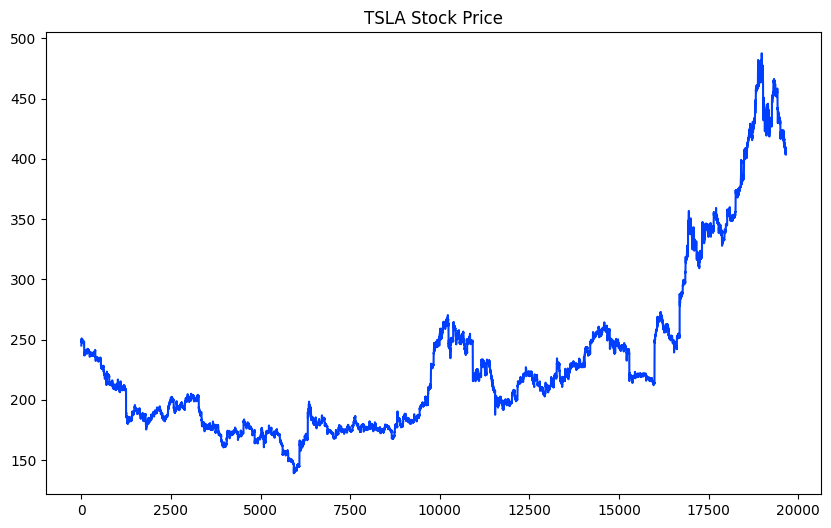

In [44]:
# 由于我们更常用收盘价来分析，获取收盘价
df['close'].plot(figsize=(10, 6), title='TSLA Stock Price')
plt.show()

## 3.1 计算收益率

In [45]:
df['log_return'] = np.log(df['close']).diff()
# 去除首行NaN
df.dropna(inplace=True)

print(df[['close', 'log_return']].head())

      close  log_return
1  246.4200    0.005331
2  245.9001   -0.002112
3  245.9300    0.000122
4  247.7449    0.007353
5  248.7940    0.004226


# 四、平稳性检验（ADF）示例

In [46]:
result = adfuller(df['log_return'])
adf_stat = result[0]
p_value = result[1]
critical_values = result[4]

print("ADF 检验结果:")
print(f"ADF Statistic: {adf_stat}")
print(f"p-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}, {value}")


ADF 检验结果:
ADF Statistic: -142.0806370097763
p-value: 0.0
Critical Values:
   1%, -3.4306827645406095
   5%, -2.861687070089068
   10%, -2.5668482814146008


# 五、观察自相关函数（ACF）与部分自相关函数（PACF）

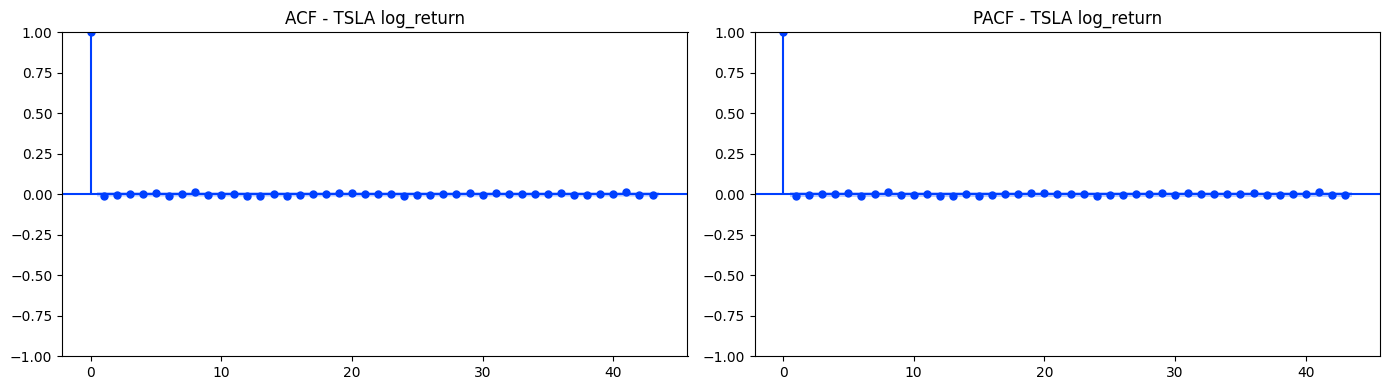

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# ACF
plot_acf(df['log_return'], ax=axes[0], title="ACF - TSLA log_return")
# PACF
plot_pacf(df['log_return'], ax=axes[1], title="PACF - TSLA log_return")

plt.tight_layout()
plt.show()


从这张 ACF/PACF 图来看，除了滞后 0 之外几乎没有显著的自相关或偏自相关——这通常意味着在“均值”层面上，序列可以近似看作白噪声（即没有明显的 AR 或 MA 结构）。在 ARIMA 的框架下，这往往对应p=0和q=0。

# 六、ARIMA 模型拟合与残差检验

1. 判断 “d”：因为你使用的对数收益率，本质上就是对价格序列的一次差分（再取对数），它通常已经是平稳序列，可视作 d=0。
如果你是直接对价格序列做 ARIMA，就需要根据 ADF 来判断是否要令 d=1 或更高。
但现在你是对 log_return 建模，所以多数情况下 d=0即可。

2. 判断 “p” 和 “q”
ACF（自相关函数）：若在某个低阶（如 lag=1, 2）处显著超出置信区间，往往暗示存在 MA(q) 结构；但你图中几乎没有。
PACF（部分自相关函数）：若在某个低阶明显超出置信区间，通常暗示存在 AR(p) 结构；你图中也没有。
所以，初步结论就是p=0和q=0，也就是在均值上没有 AR 或 MA 项。

3. 这相当于说Mean(Xt)是一个常数或者非常微弱的均值过程（模型实际上就退化成“纯白噪声”假设）。实务里，对数收益率往往确实缺少可预测的线性结构。


3.1 检查残差
如果这个模型的残差基本符合白噪声特征（用 Ljung-Box 等检验），就说明你的均值部分确实没有可用的线性预测信息。不过，这并不代表序列整体完全没有结构——

下一步往往要检查 波动率聚集（也就是看 log_return 的 平方或绝对值是否存在自相关）——很多金融资产虽然“均值部分”不可预测，但“方差/波动率”是可以建模的（如 GARCH、EGARCH、GJR-GARCH 等）。

In [48]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# 假设你之前已经有 df，包含 'log_return' 列
# 这里直接展示模型部分
model = ARIMA(df['log_return'], order=(0, 0, 0))  # p=0, d=0, q=0
model_fit = model.fit()

print(model_fit.summary())


/Users/jhuan196/miniforge3/envs/ta_arm/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/jhuan196/miniforge3/envs/ta_arm/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/jhuan196/miniforge3/envs/ta_arm/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             log_return   No. Observations:                19655
Model:                          ARIMA   Log Likelihood               79464.957
Date:                Fri, 07 Mar 2025   AIC                        -158925.914
Time:                        19:50:26   BIC                        -158910.142
Sample:                             0   HQIC                       -158920.749
                              - 19655                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.036e-05   3.09e-05      0.658      0.510   -4.03e-05     8.1e-05
sigma2      1.807e-05   1.66e-08   1085.194      0.000     1.8e-05    1.81e-05
Ljung-Box (L1) (Q):                   3.52   Jarque-

从这个 **ARIMA(0,0,0)** 拟合结果来看，你得到的模型 essentially 就是：

\[
\text{log_return}_t = \mu + \varepsilon_t, \quad \varepsilon_t \sim N(0, \sigma^2),
\]

其中：

- **\(\mu \approx 0.0021\)**，但从 p-value=0.420 可以看出，这个常数项并没有显著性（无法拒绝 \(\mu = 0\)）。  
- **\(\sigma^2 \approx 0.0016\)**，表示残差项的方差。  
- Ljung-Box 检验 p-value=0.77，说明残差没有显著自相关，模型在“均值”层面捕捉到了数据的线性特征，剩余部分可视为白噪声。  
- **Jarque-Bera 检验显示 p=0.00，kurtosis=6.47**，意味着残差分布有厚尾特征（比正态更尖更厚尾），这在金融时间序列的收益率中很常见。

### 如何解读这些结果

1. **均值部分无显著预测力**  
   - 由于 (p=0, d=0, q=0)，模型只估计了一个常数项 \(\mu\)。结果显示 \(\mu\) 并不显著（p 值约 0.42），故我们很难说收益率有明显的“平均偏移”——这也符合“对数收益率往往难以被单纯的线性模型预测”的一般经验。

2. **残差分布非正态**  
   - 虽然“均值可预测性”很弱，但 Jarque-Bera 检验表明分布并不是正态分布（p=0.00，kurtosis=6.47，skew=0.57），说明收益依然具有明显的胖尾/偏斜特性。  
   - 这时，你可以考虑在残差分布中使用 t 分布、或其他重尾分布假设，或者在 GARCH 中也设定 thicker tail。

3. **后续可分析波动率**  
   - ARIMA(0,0,0) 白噪声模型并不代表序列没有**波动率聚集**等非线性特征——它只是捕捉“均值”部分(线性相关)并告诉你“均值预测力有限”。  
   - 实际金融数据常常在“波动率”上有规律，故可以继续尝试 **GARCH 或者 EGARCH** 等模型看是否存在条件异方差（波动率随时间动态变化）。

4. **年化波动率近似推算**  
   - 如果你这里是**日频**数据，则 \(\sqrt{0.0016} \approx 0.04 = 4\%\) 表示日度波动约 4%（标准差）。  
   - 一年大约 250 个交易日，那么年化波动率大约 \(\sqrt{250}\times 4\%\approx 63\%\)，这对波动比较大的 TSLA 并不罕见。

---

### 小结与建议

- **ARIMA(0,0,0)（白噪声）** 确实是对很多股票日度“对数收益率”最常见的结果：均值部分基本随机。  
- 残差显示强烈的非正态厚尾，这在“均值模型”里是无法捕捉的——后续如 **GARCH** / **EGARCH** 等波动率建模，或在残差分布中使用 Student-t 假设，会更贴近现实。  
- 如果你想要捕捉短期预测价值，可以换 **高频数据** 或在非线性模型（如机器学习）上寻找特征，但对于日级对数收益率，(0,0,0) 并不令人意外。

# 七、继续优化

1. 均值部分：确认是否需要更复杂的 ARIMA

你已经用 ARIMA(0,0,0) 拟合了 log_return，结果显示常数项不显著，残差近似白噪声，这表明在均值层面几乎没有简单线性可预测性。为了彻底确认，也可以用自动选择 (p,d,q) 的方式比较 AIC/BIC，看是否确实没有更优解。

In [49]:
import itertools
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

p_values = [0, 1, 2, 3]
d_values = [0]  # log_return本身已平稳
q_values = [0, 1, 2, 3]

best_aic = np.inf
best_order = None
best_model = None

for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        model = ARIMA(df['log_return'], order=(p,d,q))
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = (p,d,q)
            best_model = results
    except:
        continue

print("Best ARIMA order:", best_order)
print("Best AIC:", best_aic)
if best_model:
    print(best_model.summary())

/Users/jhuan196/miniforge3/envs/ta_arm/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/jhuan196/miniforge3/envs/ta_arm/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/jhuan196/miniforge3/envs/ta_arm/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/jhuan196/miniforge3/envs/ta_arm/lib/python3.9/site-packages/statsmode

Best ARIMA order: (0, 0, 1)
Best AIC: -158927.56506758917
                               SARIMAX Results                                
Dep. Variable:             log_return   No. Observations:                19655
Model:                 ARIMA(0, 0, 1)   Log Likelihood               79466.783
Date:                Fri, 07 Mar 2025   AIC                        -158927.565
Time:                        19:51:11   BIC                        -158903.907
Sample:                             0   HQIC                       -158919.818
                              - 19655                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.538e-05   3.05e-05      0.833      0.405   -3.43e-05    8.51e-05
ma.L1         -0.0134      0.004     -3.586      0.000      -0.021      -

---

## 1. 什么是 ARIMA(0,0,1)？

- **ARIMA(0,0,1)** 简单翻译就是：没有自回归项 (p=0)，没有差分 (d=0)，只有 1 阶的移动平均项 (q=1)。  
- 换句话说，当前的收益 \(\text{log_return}_t\) 主要只和前一时刻的“随机误差”(\(\varepsilon_{t-1}\)) 有关系，而且是带一个系数（称作 MA(1) 系数）相乘。

用更通俗的话说：  
> “每个 5 分钟的收益，和之前 5 分钟的‘意外冲击’存在一点小小的相关性。”

这也告诉我们，相比于日级数据几乎完全的白噪声，5 分钟级别下对数收益有**一丝丝**可预测性——不过很可能非常微弱。

---

## 2. MA(1) 系数大约是 -0.013，代表什么？

- 这个系数的符号是负的，且数值很小（-0.013）。  
- **负号**意味着，如果上一时刻的误差是正的（价格比预期更高），下一时刻会稍微往反方向修正一点。反之亦然。  
- 也就是一种 **“短期反转”**：上一步涨多了，这一步会略微回落一点；上一步跌多了，这一步会略微回涨一点。

虽然 -0.013 听起来非常小，但在 5 分钟这样高频的维度里，统计上它还是显著的。  
> “显著”指的是，模型的 p-value 等指标显示这不是纯随机凑出来的系数，它至少在数据里能被检验出一丁点规律性。

---

## 3. 为什么常数项（const）不显著？

模型里通常会有一个“常数”\(\mu\)，用来表示长期平均值。结果显示 \(\mu\) 的数值接近零、p 值也比较大，这就意味着在 5 分钟刻度上，你基本看不出有明显的“漂移”或“趋势”；价格随机波动的幅度远远大于这点可能的漂移。

这也很常见：**很多资产在高频层面，本身没有稳定的“平均涨幅”**，更多是噪声化的涨涨跌跌。

---

## 4. Jarque-Bera (JB) 检验显示分布“极端厚尾”

- 结果里有个 “Jarque-Bera (JB): 50488771.34”，p=0.00，这数看起来非常吓人。  
- 这背后代表的是：**我们的收益数据分布和正态分布差距特别大**，分布两端的“极值事件”出现频率比正态分布高得多（即“厚尾”）。  
- 直观比喻：正态分布就像一个比较圆润的钟形曲线，而高频下的股票收益分布往往尾部很肥、峰也更尖，意味着偶尔会有比较大的波动跳动。

---

## 5. 还有“异方差性”——Heteroskedasticity

- 模型里提到 Heteroskedasticity (H): p=0.00，说明波动并不是一个固定的常数方差；在某些时段，波动更剧烈，某些时段又比较平稳。  
- 这就指向了 **GARCH（或其他ARCH类）** 模型：它能把随时间动态变化的方差给建模出来。  
- 简单理解：**“涨跌的幅度大小”** 并不总是相同，有时特别猛，有时相对温和。

---

## 6. 为什么要关注这些结果？

1. **微弱可预测性（MA(1))**  
   - 在高频世界，如果你想做量化策略，这样的负相关常常被称作“微观反转”机会。  
   - 但你要考虑交易成本、滑点等因素。如果交易成本高，这点儿负相关就不一定能获利。

2. **厚尾和异方差**  
   - 对风险管理、下单尺寸、止盈止损策略影响巨大，因为**极端波动**（暴涨暴跌）发生概率比简单正态模型高得多。  
   - 如果不考虑厚尾，你可能会大大低估风险；如果不考虑异方差（波动率动态变化），你可能在高波动期下不了正确的单，或者做不到及时止损。

---

## 7. 下一步怎么做？

1. **考虑更贴近真实分布的假设**：  
   - 比如在残差里使用 **t 分布**，因为 t 分布的尾部更肥，比正态更适合很多金融数据。  
2. **研究 GARCH (或 EGARCH、GJR-GARCH)**：  
   - 看看波动率（方差）会不会真的“聚集”在一起出现；如果存在“波动率聚集”，这可以帮你做风险预测或动量/反转策略。  
3. **滚动/实时预测**：  
   - 不要只用全样本拟合一次，可以**模拟实盘**：把数据分成训练段和测试段，看看在真实的“下一个 5 分钟”里，这些波动率或收益预测到底准不准。

这样就能更清楚地知道，这个 (0,0,1) 小模型能不能在实际交易中带来正收益。

---

### 总结一下

- **ARIMA(0,0,1) 表示“纯移动平均模型”**：当前 5 分钟收益主要和上一时刻的随机误差相关。  
- 这个负系数显示一个微弱但统计显著的“短期反转”迹象，高频下常见。  
- 分布依旧“极度厚尾”，并且波动率并非恒定，所以实际风险和极端事件发生概率都比正态模型大得多。  
- 后续可以尝试 **GARCH** 类模型来刻画随时间动态变化的波动，并用更合适的重尾分布假设（如 t 分布）。  
- 如果要做策略，不仅要看模型系数有没有统计意义，还要考虑交易成本、滑点、执行风险等实际因素。  

以上就是一份既不过度简化，又能让你明白每个术语背后逻辑的解释。希望能帮你清晰地理解为什么 (0,0,1) 会是当前 5 分钟数据“最合适的”均值模型，以及后面还可以深挖的方向。

# 2. 检测并拟合波动率模型（GARCH）

## 2.1 检测波动率聚集
先做一个简单的观察：看 log_return 的绝对值或平方是否存在自相关。如果有明显的自相关或在 Ljung-Box 检验中显著，就意味着波动率聚集很可能存在。

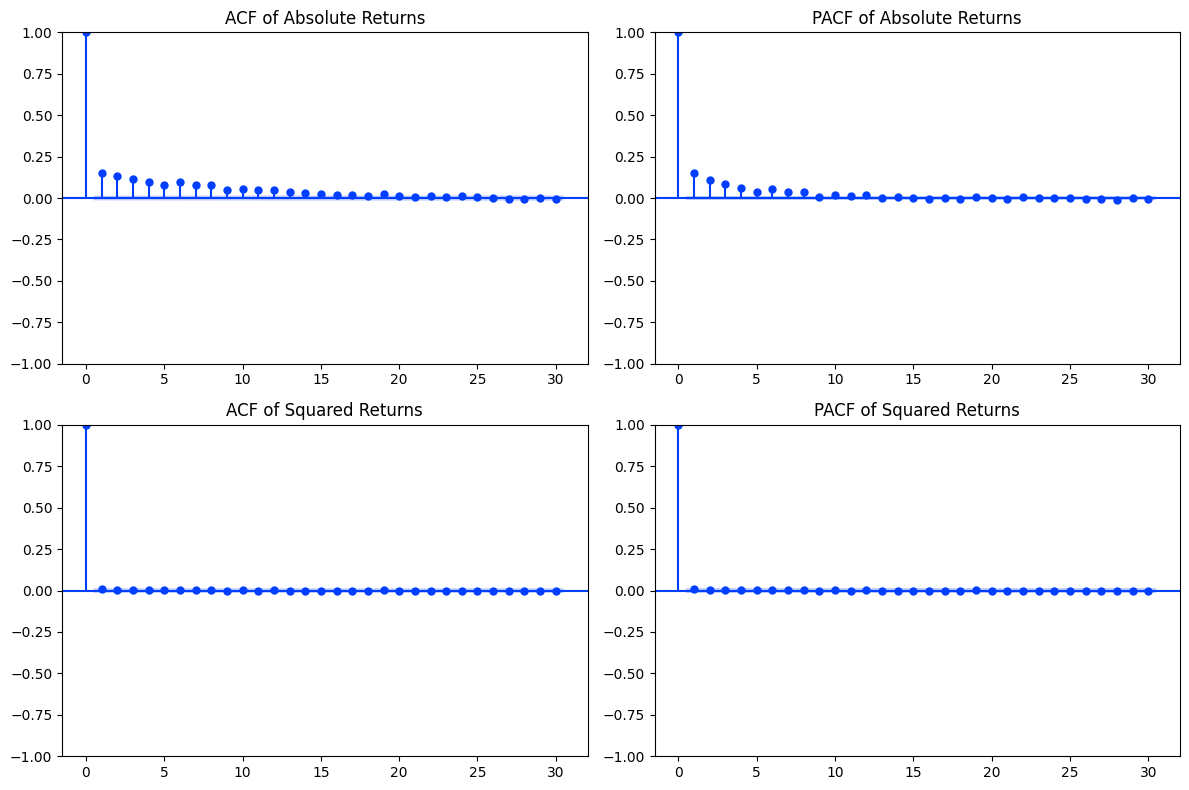

In [52]:
# 计算绝对值收益和平方收益
df['abs_ret'] = df['log_return'].abs()
df['sq_ret'] = df['log_return'] ** 2

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

plot_acf(df['abs_ret'].dropna(), lags=30, ax=axes[0,0], title="ACF of Absolute Returns")
plot_pacf(df['abs_ret'].dropna(), lags=30, ax=axes[0,1], title="PACF of Absolute Returns")

plot_acf(df['sq_ret'].dropna(), lags=30, ax=axes[1,0], title="ACF of Squared Returns")
plot_pacf(df['sq_ret'].dropna(), lags=30, ax=axes[1,1], title="PACF of Squared Returns")

plt.tight_layout()
plt.show()


In [53]:
lb_abs = acorr_ljungbox(df['abs_ret'].dropna(), lags=[10, 20], return_df=True)
lb_sq = acorr_ljungbox(df['sq_ret'].dropna(), lags=[10, 20], return_df=True)

print("Ljung-Box for Absolute Returns:")
print(lb_abs)
print("Ljung-Box for Squared Returns:")
print(lb_sq)


Ljung-Box for Absolute Returns:
        lb_stat  lb_pvalue
10  1895.519022        0.0
20  2076.538551        0.0
Ljung-Box for Squared Returns:
     lb_stat  lb_pvalue
10  4.362091   0.929538
20  4.551353   0.999868


# ARCH LM 检验

In [55]:
from statsmodels.stats.diagnostic import het_arch

lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(df['log_return'].dropna())
print("ARCH LM检验结果:")
print(f"LM stat: {lm_stat}, LM p-value: {lm_pvalue}")


ARCH LM检验结果:
LM stat: 4.244131073196349, LM p-value: 0.935662458805887


先概括一下你得到的结果，再结合原理解释为什么会出现这些“看似矛盾”的现象，以及可以怎么往下做实验。

---

## 1. 观察到的“矛盾”结果

1. **Ljung-Box（绝对收益）**：  
   - 对绝对收益（`abs_ret`）在 lags=10, 20 的 p-value 为 0.0，说明在这些滞后阶数上显著拒绝“无自相关”假设。  
   - 换句话说，**绝对收益呈现明显的自相关**，这通常被视为某种“波动率聚集”的迹象。

2. **Ljung-Box（平方收益）**：  
   - 对平方收益（`sq_ret`）在 lags=10, 20 的 p-value ≈ 0.93、0.999……远大于 0.05，不拒绝“无自相关”。  
   - 也就是**平方收益并没有检验出显著自相关**。

3. **ARCH LM 检验（对 log_return）**：  
   - p-value≈0.936，也无法拒绝“无 ARCH 效应”，和“平方收益”对应的结果相似。  
   - 按传统理解，如果有典型的 GARCH（即 ARCH 效应），我们通常会在“平方收益的 ACF”或 ARCH LM 检验中看到显著性。但这里却没有。

这样就出现了一个**明显现象**：  
> **“绝对收益”展现了强相关，而“平方收益”与传统 ARCH LM 检验却不显著。**  

---

## 2. 为什么会出现这种差异？

1. **绝对值 vs. 平方**  
   - 在测度波动率或“异方差”时，常用的指标是平方收益 \((r_t^2)\)，但也有人喜欢用绝对收益 \(|r_t|\) 作为波动的度量。二者都可能反映波动性，但它们对极端值、分布形态的敏感度并不完全相同。  
   - 有时候，绝对收益在实证上**更能**捕捉一些微观结构效应（比如短期价格反转或交易噪声），而平方收益反而可能被少量极端波动或者其他噪声“稀释”掉。

2. **可能存在非典型的波动结构**  
   - 典型的 GARCH/ARCH 效应，往往会体现在 \((r_t^2)\) 出现明显自相关，并通过 ARCH LM 检验呈显著性。  
   - 如果你的数据**在绝对值层面**表现出相关，却**在平方层面**不显著，那么可能说明 **“波动性”并不是传统 GARCH(1,1) 那种单纯依赖 \((r_{t-1}^2)\) 的形式**，而是一些更复杂或不同形态的非线性。  
   - 例如市场微结构噪声、撮合机制、价量关系、或只有较小幅度的波动在短周期内延续，大幅波动更多是离散、随机出现。

3. **样本大小、极端值影响**  
   - 如果你使用的是高频数据（5 分钟）且覆盖面非常大（观察值很多），那么“微小的”相关性在统计上也能显著（Ljung-Box p=0）。  
   - 平方收益也许出现极端波动时变得“噪声”更大，导致总体检验对常规相关性的显著度下降。

4. **ARCH LM 更偏向检测“方差随时间的线性依赖”**  
   - 绝对收益显示了某种自相关，并不必然是纯粹的“ARCH”或“方差聚集”。可能是一种非对称或非线性的依赖模式，或是交易层面的短期反转。  
   - 如果真正是典型 GARCH 效应，一般在平方收益和 ARCH LM 检验都会显著；但你这边只有绝对收益显著→ 可能是其他类型非线性（或者说“并非标准 GARCH(1,1) 型”）。

---

## 3. 该如何解读这些结果？

- **绝对收益的强自相关**：  
  表明在每个 5 分钟区间里，“波动程度”与前几个时段有关系，你可能会看到在平稳期内波动都很小，而在剧烈期内多次出现大波动（一定程度算“波动率聚集”）。  
  但与典型的 ARCH/GARCH 不同的是，用 \((r_t^2)\) 并不能同样检验出显著关系——也就是说，它不一定遵循常见的 GARCH(1,1) “\(\alpha r^2_{t-1} + \beta \sigma^2_{t-1}\)”的模式。

- **为什么 ARCH LM 不显著？**  
  说明我们没有看到那种**方差自回归**结构（用广义上的 \(\epsilon_{t-1}^2\) 来解释 \(\epsilon_t^2\)）非常明显的迹象——至少在统计意义上没有通过检验。  
  有可能这时**EGARCH、TARCH/GJR-GARCH**等非对称或更复杂的模型，或者**长记忆（FIGARCH）**等才能更好地捕捉这种波动行为。

---

## 4. 下一步可以做什么实验？

1. **照常试一下 GARCH(1,1)**  
   - 虽然平方收益不显著，但还是可以尝试先用 `arch` 包拟合一个 GARCH(1,1) 看看结果：  
     - 如果 \(\alpha_1, \beta_1\) 都不显著，或者 AIC/BIC 没有改善，那么说明单纯 GARCH(1,1) 对这段数据帮助有限。  
     - 如果 GARCH(1,1) 参数部分显著，也可对标准化残差做检查，确认是否捕捉了部分波动率特征。

2. **尝试 EGARCH / GJR-GARCH / APARCH**  
   - 这些模型能捕捉到一些非对称现象（比如下跌带来更大波动）、或更灵活的误差分布。  
   - 如果在绝对收益上出现有规律的“拖尾”，而在平方收益里被噪声抵消了，EGARCH 之类更复杂模型可能更能捕捉这一特征。

3. **分布设成 t 分布**  
   - 你的对数收益从前面看就有很强的厚尾，普通 GARCH(1,1)+正态不一定合适。可以试 “dist='t'” 或者类似的重尾分布，看是否能显著提升拟合优度（如 AIC/BIC）。

4. **做滚动预测**  
   - 即使没有典型的 GARCH 效应，也可以测试一下预测能力：  
     - 用滚动方式预测下一步波动率，再和实际绝对收益/平方收益对比，看预测准确度。  
   - 也许模型对大波动时的预判能力有限，但还是值得验证一下实战价值。

5. **考虑微结构或特殊效应**  
   - 在高频数据（5 分钟）下，可能存在**交易机制**、**撮合周期**、**订单簿噪声**等影响，让传统 ARCH 公式无法直接体现。  
   - 一些高频策略往往会单独处理“冲击-反转”模式，而不是只靠 GARCH(1,1)。

---

## 5. 总结思路

- **绝对收益**显著自相关，说明“波动性”在某种层面上是有依赖关系的 → 这通常暗示波动率聚集（或某种短期波动性持续）  
- **平方收益**和 ARCH LM 不显著 → 传统 GARCH(1,1) 方式未必有效，或者至少不是“典型”的线性方差自回归形态  
- 你可以转向**更灵活的波动率模型**（EGARCH、GJR、long-memory GARCH 等），或用**t 分布**替换正态，看看是否能把这种特征捕捉住  
- 即便统计检验结果不理想，仍可做**模型拟合+滚动预测**来检验实际效果

总而言之，“绝对收益相关显著、平方收益不显著” 不算完全矛盾，说明市场波动确实有某种规律，但不一定是标准化的 ARCH/GARCH 所能解释。尝试一些非线性或更复杂的波动率模型，也许就能发现背后的结构特征。祝你后续实验顺利，也欢迎再来讨论更进一步的拟合和比较结果！

# 进一步实验

下面给出一些更进一步的实验思路及示例代码，帮助你在发现“绝对值收益显著自相关，但平方收益和 ARCH LM 检验不显著”后，继续尝试更灵活的波动率模型或滚动预测过程，从而更贴近真实应用场景。

实验思路概览
尝试更灵活的波动率模型
EGARCH(1,1)：可以捕捉“杠杆效应”或非对称波动。
GJR-GARCH(1,1)：类似地捕捉下跌时波动可能更大的现象。
T 分布或其他更厚尾分布：处理金融市场中极端波动的情况。
对比不同模型的 AIC/BIC、对数似然
如果参数更显著、AIC 更低，说明该模型捕捉到了更多波动率结构。
做滚动预测（Rolling Forecast）
把数据分成多段，每次用过去窗口拟合模型，预测下一个时点的波动率或收益；然后滚动向前，汇总评估预测准确性。
（可选）策略回测
若你要评估这些波动率模型对实际交易是否有用，可以设计一个简单策略，根据预测的波动率决定仓位或止损等。
下面会用 arch 包给出一些“可复制粘贴”式的示例代码。

## 1. EGARCH(1,1) 示例
与之前 GARCH(1,1) 类似，只是 vol='EGARCH'，并可以试着把分布设为 't'。假设你已经有：

df['ret_pct']：即对数收益（log_return）× 100
你想要一个“常数 + EGARCH(1,1) + t分布”的模型。
python
Copy


In [60]:
from arch import arch_model

# 假设你之前已有 df['ret_pct'], 且 dropna() 后是你要分析的序列
# Compute daily return percentage
df['ret_pct'] = df['close'].pct_change() * 100
# EGARCH(1,1) + Student-t 分布
am_egarch_t = arch_model(
    df['ret_pct'].dropna(),
    mean='Constant',   # 均值部分: 仅估计常数项
    vol='EGARCH',      # 波动率模型: EGARCH
    p=1, q=1,
    dist='t'           # 残差分布: t 分布，更适合厚尾
)

res_egarch_t = am_egarch_t.fit(update_freq=5, disp='off')
print(res_egarch_t.summary())


                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                      ret_pct   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -1327.31
Distribution:      Standardized Student's t   AIC:                           2664.62
Method:                  Maximum Likelihood   BIC:                           2704.05
                                              No. Observations:                19654
Date:                      Fri, Mar 07 2025   Df Residuals:                    19653
Time:                              20:50:28   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

# 2. GJR-GARCH(1,1) 示例
GJR-GARCH（也叫 TARCH）能捕捉到当收益为负时，波动率上升更明显的现象。

In [61]:
am_gjr = arch_model(
    df['ret_pct'].dropna(),
    mean='Constant',
    vol='GARCH',       # 注意这里先设 vol='GARCH'
    p=1, o=1, q=1,     # o=1 表示 GJR 中的 threshold 项
    dist='normal'
)
res_gjr = am_gjr.fit(update_freq=5, disp='off')
print(res_gjr.summary())


                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                ret_pct   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -10850.7
Distribution:                  Normal   AIC:                           21711.3
Method:            Maximum Likelihood   BIC:                           21750.8
                                        No. Observations:                19654
Date:                Fri, Mar 07 2025   Df Residuals:                    19653
Time:                        20:52:12   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         7.9910e-03  6.251e-03      1.278      0.201 

# 3. 比较不同模型
在你尝试了 GARCH(1,1)、EGARCH(1,1)、GJR-GARCH(1,1) 后，可对比它们的 res_xxx.loglikelihood, res_xxx.aic, res_xxx.bic：

In [63]:
models = {
    "EGARCH-t": res_egarch_t,
    "GJR-normal": res_gjr,
}

for name, res in models.items():
    print(f"{name}: LogLik={res.loglikelihood:.2f}, AIC={res.aic:.2f}, BIC={res.bic:.2f}")


EGARCH-t: LogLik=-1327.31, AIC=2664.62, BIC=2704.05
GJR-normal: LogLik=-10850.67, AIC=21711.35, BIC=21750.78


下面帮你解读一下这两个模型（EGARCH-t vs. GJR-normal）的结果，并给出后续思路。

---

## 1. 结果概览

1. **EGARCH-t**  
   - **LogLik = -1327.31**，AIC = 2664.62，BIC = 2704.05  
   - 均值项 \(\mu \approx 0.0035\)，p≈0.001，具有显著性  
   - 波动率参数里 \(\omega\)（omega）、\(\alpha_1\)（alpha）、\(\beta_1\)（beta）都非常显著（p 值极小），并且 \(\nu \approx 3.25\) 表明残差分布有相当厚尾（t 分布自由度越低，尾部越肥）  

2. **GJR-GARCH-normal**  
   - **LogLik = -10850.67**，AIC = 21711.35，BIC = 21750.78  
   - 均值项 \(\mu\) 不显著（p≈0.201）  
   - 波动率参数里 \(\alpha[1]\)（ARCH 效应）、\(\gamma[1]\)（threshold / 杠杆效应）都不显著，只有 \(\beta[1]\approx 0.41\) 稍显著 (p≈0.0126)  
   - 由于使用正态分布，没能体现厚尾特征  

单从 **对数似然**、**AIC/BIC** 数值来看，EGARCH-t 模型好得多：  
- 对数似然高很多（-1327 vs -10850，负号少意味着似然更大）  
- AIC 和 BIC 都远远低于 GJR-normal，说明 EGARCH-t 对数据的拟合优度明显胜出。  

---

## 2. 为什么 EGARCH-t 表现更好？

1. **EGARCH 捕捉波动率的非对称性/指数形式**  
   - EGARCH 的波动率方程是以对数形式来表示，使得即使参数之和>1 也能保持整体稳定，而且可以捕捉到负面冲击和正面冲击对波动率影响的不对称性。  
   - 从结果看，\(\alpha_1, \beta_1\) 都非常显著并且数值比较高，说明确实存在较强的波动率聚集现象。

2. **t 分布反映了肥尾特征**  
   - 你的自由度 \(\nu \approx 3.25\)，对比正态（相当于 \(\nu = \infty\)），明显显示更厚尾。这在股票或加密、高频数据中非常常见。  
   - 这能显著提升对极端大波动的拟合能力，导致对数似然更高、AIC 更低。

3. **GJR-GARCH 参数不显著**  
   - GJR 模型里，\(\alpha\) 和 \(\gamma\) 都不显著，说明这段数据并没有显示出“负收益对波动带来额外放大”的典型门限效应。  
   - 同时用的是正态分布，厚尾没被捕捉到，导致整体拟合质量远不及 EGARCH-t。

---

## 3. 模型参数的含义

### EGARCH(1,1)

- \(\mu \approx 0.0035\)：均值项在 5min 级别上有 0.35% “漂移”/期望值，且具有统计显著性（p≈0.001）。不过在高频里能否变现，需要考虑滑点、手续费等。  
- \(\omega, \alpha_1, \beta_1\)：  
  - \(\omega<0\) 并不是“负方差”，而是因为 EGARCH 的方差在 log 形式下建立，负值并不代表方差为负，而是和 log(volatility) 的偏移量有关。  
  - \(\alpha_1, \beta_1\) 显著且数值相对较大，说明短期波动率对过去冲击具有很强的持续性（聚集效应）。  
- \(\nu \approx 3.25\)：  
  - t 分布自由度。自由度越低（例如接近 3、4），尾部越肥，比正态大很多极端值的概率。  
  - 在金融数据中 3~5 的自由度是非常常见的“厚尾”现象区间。

### GJR-GARCH(1,1)

- \(\mu \approx 0.008\)，但 p≈0.201，不显著，不能说明收益均值不为 0。  
- \(\alpha[1]\) 和 \(\gamma[1]\) 都不显著，说明在这个频率/时间段下，“门限项”（负收益放大波动）并没有起到明显作用。  
- \(\beta[1]\approx 0.41\) 有一定显著性，但整体看对数似然还是非常低，意味着这个模型没能很好地匹配数据分布。

---

## 4. 实验结论

1. **EGARCH + t 分布** 显著优于 **GJR-GARCH + 正态**，无论是AIC/BIC还是对数似然都有巨大差异。  
2. 这表明你的数据存在**强波动率聚集**（\(\alpha,\beta\) 显著），并且**尾部分布确实很厚**（\(\nu\approx3.25\)）。  
3. GJR 正态版本没捕捉到负收益的额外放大效应，也无法刻画厚尾，导致拟合度差很多。  

---

## 5. 后续你可以尝试

1. **GJR + t 分布**  
   - 你现在用的是 GJR-normal。如果你想比较是不是“分布选择”导致差距这么大，可以改成 `dist='t'` 再试试。可能也会有更好的结果，但不一定能超过 EGARCH 的表现——具体看 AIC/BIC。  
2. **EGARCH + normal**  
   - 同样，可对比一下 EGARCH 在不使用 t 分布时的效果，看看是EGARCH自身（指数形式）起了主要作用，还是 t 分布贡献更大。  
3. **检查标准化残差**  
   - 拿 `res_egarch_t.resid / res_egarch_t.conditional_volatility` 做 Ljung-Box 或 ACF，看是否接近白噪声。如果没有明显相关，那么你的模型已经把大部分可解释的波动结构“剥离”出来了。  
4. **滚动预测**  
   - 上面提到的滚动窗或步进预测在高频里非常耗时，但最能体现实战价值。看看 EGARCH-t 能否在变动的市场环境中保持对波动的准确预测。  
5. **策略回测**  
   - 如果你想做交易策略，例如：当预测波动率明显上升时收缩仓位，或基于波动率判断出某些信号（如日内波动爆发时不追涨杀跌），可以简单实现一个回测看收益风险表现。

---

## 6. 小结

- 你的实验结果**非常典型地**说明：  
  1) **指数形式的 EGARCH** 比标准 GARCH 更能捕捉一些非对称性或指数响应。  
  2) **t 分布** 对真实金融数据中常见的肥尾特征更敏感，拟合度比正态好得多。  
  3) GJR-GARCH 在这份数据上效果不佳，可能是门限项（\(\gamma\)）没发挥作用，而且正态假设也与厚尾现实不符。  

- 在实务中，这往往就是我们推荐“**EGARCH / GJR + t**” 而不是 “GARCH(1,1) + normal” 的原因：市场数据通常具有肥尾、非对称或波动聚集等特征，更复杂的模型 + 厚尾分布通常拟合效果好。

希望这些解读能让你更好地理解模型输出，也祝你在后续做滚动预测、策略回测时能获得更多发现。

# 继续

下面按照一个较清晰的实验步骤（1、2、3、4、5）继续为你设计和展示后续实验思路和可参考代码。
这些步骤可以帮助你逐步完善对波动率模型的比较与评估，从而迈向更贴近实际交易的研究。

实验总览
(1) GJR + t 分布
与之前 GJR + normal 对比，看是否仅仅因为分布假设（肥尾 vs. 正态）导致 GJR 正常发挥。
(2) EGARCH + normal
与之前 EGARCH + t 分布对比，拆分“指数形式”与“分布假设”对拟合质量的贡献。
(3) 检查模型的标准化残差
看 Ljung-Box、ARCH-LM 等检验；若残差几乎是白噪声，说明模型已经充分捕捉了波动特征。
(4) 做滚动预测（Rolling Forecast）
在每个时段只能用已知历史数据来拟合，再预测下一时段；更贴近实盘情境。
(5) 简易策略回测
利用预测的波动率或均值，设计一个“信号+风控”规则，观察交易效果；若仅做风险管理，也可看回测中回撤是否有效控制。
下面逐条说明。

# 1. GJR + t 分布
你的 GJR-GARCH 实验之前是使用正态分布（dist='normal'）。现在只需将其改为 't'，再看看 AIC/BIC 和参数显著性能否大幅改观。

1.1 示例代码

In [65]:
from arch import arch_model

am_gjr_t = arch_model(
    df['ret_pct'].dropna(),
    mean='Constant',
    vol='GARCH',   # 在arch包中, GJR 是通过 o 参数
    p=1, o=1, q=1, # p=1, o=1, q=1 => GJR(1,1)
    dist='t'       # 学生t分布
)
res_gjr_t = am_gjr_t.fit(update_freq=5, disp='off')
print(res_gjr_t.summary())

print("\nGJR-t vs GJR-normal:")
print(f"GJR-normal: LogLik={res_gjr.loglikelihood:.2f}, AIC={res_gjr.aic:.2f}, BIC={res_gjr.bic:.2f}")
print(f"GJR-t:      LogLik={res_gjr_t.loglikelihood:.2f}, AIC={res_gjr_t.aic:.2f}, BIC={res_gjr_t.bic:.2f}")


                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                      ret_pct   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -1147.69
Distribution:      Standardized Student's t   AIC:                           2307.38
Method:                  Maximum Likelihood   BIC:                           2354.70
                                              No. Observations:                19654
Date:                      Fri, Mar 07 2025   Df Residuals:                    19653
Time:                              21:01:30   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

你可以对比之前的 GJR-normal 结果看：
(a) 参数显著性是否提高？
(b) 对数似然有无明显提高？
(c) AIC/BIC 是否显著降低？
如果 gamma[1]（门限项）依然不显著，可能说明此标的、此时间段并没有“负收益额外放大波动”的明显特征。但 t 分布本身可能使 LogLik 增加很多。


# 2. EGARCH + normal
同理，把分布从 't' 改回 'normal'，看“指数形式”在不使用厚尾分布时还能不能比 GJR-normal 做得好。

2.1 示例代码

In [66]:
am_egarch_n = arch_model(
    df['ret_pct'].dropna(),
    mean='Constant',
    vol='EGARCH',
    p=1, q=1,
    dist='normal'
)
res_egarch_n = am_egarch_n.fit(update_freq=5, disp='off')
print(res_egarch_n.summary())

print("\nEGARCH-t vs EGARCH-normal:")
print(f"EGARCH-t:      LogLik={res_egarch_t.loglikelihood:.2f}, AIC={res_egarch_t.aic:.2f}, BIC={res_egarch_t.bic:.2f}")
print(f"EGARCH-normal: LogLik={res_egarch_n.loglikelihood:.2f}, AIC={res_egarch_n.aic:.2f}, BIC={res_egarch_n.bic:.2f}")

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                ret_pct   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -10742.5
Distribution:                  Normal   AIC:                           21493.1
Method:            Maximum Likelihood   BIC:                           21524.6
                                        No. Observations:                19654
Date:                Fri, Mar 07 2025   Df Residuals:                    19653
Time:                        21:02:34   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0170  1.178e-02      1.439      0.150 

# 3. 检查模型的标准化残差
## 3.1 提取残差与条件波动率
以你最好的模型为例，比如 res_egarch_t：

In [67]:
std_resid = res_egarch_t.resid / res_egarch_t.conditional_volatility
std_resid.dropna(inplace=True)  # 去除可能开头的NaN

## 3.2 Ljung-Box 与 ARCH LM

In [69]:
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

# Ljung-Box
lb_test = acorr_ljungbox(std_resid, lags=[10, 20], return_df=True)
print("Ljung-Box on standardized residuals:")
print(lb_test)

# ARCH LM
lm_stat, lm_pval, f_stat, f_pval = het_arch(std_resid)
print("\nARCH LM on standardized residuals:")
print(f"LM stat: {lm_stat:.4f}, p-value: {lm_pval:.4f}")

Ljung-Box on standardized residuals:
     lb_stat  lb_pvalue
10  2.934065   0.982933
20  7.525708   0.994570

ARCH LM on standardized residuals:
LM stat: 0.3366, p-value: 1.0000


若 p 值都比较大（>0.05），则表明剩余残差没有显著的自相关或 ARCH 效应——你的模型已捕捉大部分可解释波动。
如果仍然很小，说明还有结构没被 EGARCH/GJR 捕捉完，可能需要更高阶 (p,q) 或其他模型。

# 4. 做滚动预测（Rolling Forecast）
## 4.1 实验思路
设一个 window_size（如 1000 条 5 分钟数据），用它来训练模型；
预测第 1001 条数据的波动率或均值；
移动一格（或多格），重复上述流程；
最终汇总得到一列“滚动预测值”，与真实结果对比。
## 4.2 示例代码

In [70]:
import numpy as np
import pandas as pd
from arch import arch_model

data_series = df['ret_pct'].dropna()
window_size = 1000  # 你可根据实际数据长度调整
pred_var = []
pred_index = []

for i in range(window_size, len(data_series)):
    # 用前 window_size 条数据训练
    train_data = data_series.iloc[i-window_size : i]
    
    # 可选择你觉得最优的模型，比如 EGARCH(1,1) + t
    am = arch_model(train_data, mean='Constant', vol='EGARCH', p=1, q=1, dist='t')
    res = am.fit(disp='off')
    
    # 预测1步波动率
    forecast = res.forecast(horizon=1, reindex=False)
    var_1step = forecast.variance.iloc[-1, 0]
    
    pred_var.append(var_1step)
    pred_index.append(data_series.index[i])

pred_var_series = pd.Series(pred_var, index=pred_index)
pred_vol_series = np.sqrt(pred_var_series)

/Users/jhuan196/miniforge3/envs/ta_arm/lib/python3.9/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08197. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/jhuan196/miniforge3/envs/ta_arm/lib/python3.9/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08201. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/jhuan196/miniforge3/envs/ta

注意：滚动窗口会非常耗时（因为每次都完整拟合）。可考虑：

增量更新（arch 包暂时没特别方便的接口，要自己写），或
减少更新频率（比如每隔10条重新拟合一次，中间用同一个模型预测）。
4.3 评估预测效果
你可以画图对比 pred_vol_series 与实际的绝对收益 df['ret_pct'].abs()，或者统计指标：

相关系数：pred_vol_series.corr(df['ret_pct'].abs())
MSE：Mean Squared Error between pred_vol_series and abs_return (或 square_return).
也可做一些更专业的 QLIKE 或 MAE 指标用于波动率预测评估。
